# Modzy Jobs API with Python SDK  
In this notebook, we will use the Modzy Python SDK to make an inference call to a model.

For more detailed usage documenation for our Python SDK, visit our **[GitHub page](https://github.com/modzy/sdk-python)**. 

### 1. Environment Set Up

Create a virtual environment (venv, conda, or other preferred virtual environment) with Python 3.6 or newer. 

Pip install the following packages in your environment. 

* modzy-sdk==0.5.4
* opencv-python==4.5.2.54
* numpy==1.21.0
* matplotlib==3.4.2
* notebook==6.4.0 **OR** jupyterlab==3.0.16

### 2. Import Modzy SDK and Initialize Client

Insert your instance URL and personal API Key to establish connection to the Modzy API Client

In [1]:
# Import Libraries
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from modzy import ApiClient, error
from utils import display_rle_mask

#### Initialize Modzy API Client

In [ ]:
# the url we will use for authentication
'''
Example: if your instance URL is "https://test.modzy.url", the URL here would be "https://test.modzy.url/api"
'''
API_URL = "https://<your.modzy.url>/api"
# the api key we will be using for authentication -- make sure to paste in your personal API access key below
API_KEY = "<your.api.key>"

if API_URL == "https://<your.modzy.url>/api":
    raise Exception("Change the API_URL variable to your instance URL")
elif API_KEY == "<your.api.key>":
    raise Exception("Insert your API Key")
    
# setup our API Client
client = ApiClient(base_url=API_URL, api_key=API_KEY)

### 3. Discover Available Models
Query the available models in your environment

In [4]:
# Combine all information for each available model into a list
all_models = [client.models.get(model["modelId"]) for model in client.models.get_all()]

In this notebook, we will run inference for the Automobile Classification Model

In [5]:
# Extract information for Automobile Classification model
auto_model_info = [model for model in all_models if model["name"] == "Automobile Classification: Explainable"][0]
pprint(auto_model_info)

{'author': 'Open Source',
 'description': 'This model can perform car recognition on street shots of '
                'vehicles and provide an explanation for each prediction.',
 'features': [{'description': 'This model has a built-in adversarial defense '
                              'feature. Click '
                              '[here](https://arxiv.org/abs/1907.07732) to '
                              "read more about Modzy's proprietary adversarial "
                              'defense strategy.',
               'identifier': 'built-in-adversarial-defense',
               'name': 'Adversarial'}],
 'images': [{'caption': 'Automobile Classification: Explainable',
             'relationType': 'background',
             'url': '/modzy-images/132fq7a6a9/image_background.png'},
            {'caption': 'Automobile Classification: Explainable',
             'relationType': 'card',
             'url': '/modzy-images/132fq7a6a9/image_card.png'},
            {'caption': 'Automobile Cl

In [31]:
# Define Variables for Inference
MODEL_ID = auto_model_info["modelId"]
MODEL_VERSION = auto_model_info["latestVersion"]
INPUT_FILENAME = list(client.models.get_version_input_sample(MODEL_ID, MODEL_VERSION)["input"]["sources"]["car.jpg"].keys())[0]
sources = {INPUT_FILENAME: "./bmw.jpg"}

### 4. Submit Inference to Model

#### Helper Function
Below is a helper function we will use to submit inference jobs to the Modzy platform and return the model output using the `submit_files` method. For additional job submission methods, visit the **[jobs page](https://github.com/modzy/sdk-python/blob/main/modzy/jobs.py)** within the Python SDK GitHub page.

In [32]:
def get_model_output(model_identifier, model_version, data_sources, explain=False):
    """
    Args:
        model_identifier: model identifier (string)
        model_version: model version (string)
        data_sources: dictionary with the appropriate filename --> local file key-value pairs
        explain: boolean variable, defaults to False. If true, model will return explainable result
    """
    job = client.jobs.submit_files(model_identifier, model_version, data_sources, explain)
    result = client.results.block_until_complete(job, timeout=None)    
    model_output = result.get_first_outputs()['results.json']
    
    return model_output

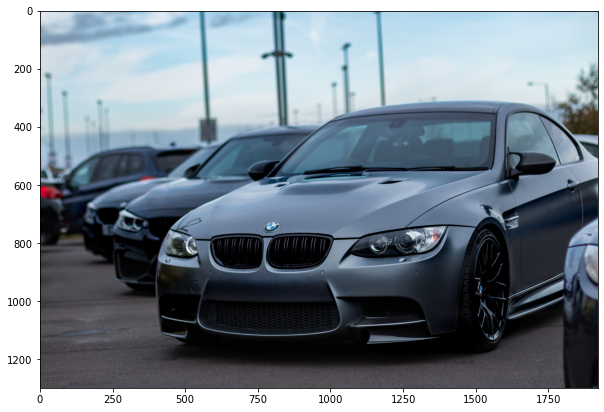

In [33]:
# Visualize image to use for inference
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread("./bmw.jpg"),cv2.COLOR_BGR2RGB));

In [36]:
model_results = get_model_output(MODEL_ID, MODEL_VERSION, sources, explain=True)
non_explainable_results = {
    "topPrediction": {
        "class": model_results["data"]["result"]["classPredictions"][0]["class"],
        "probability": model_results["data"]["result"]["classPredictions"][0]["score"]   
    }
}
pprint(non_explainable_results)

{'topPrediction': {'class': 'BMW M3 Coupe 2012', 'probability': 0.799}}


### 5. Plot Explainability Mask on Image

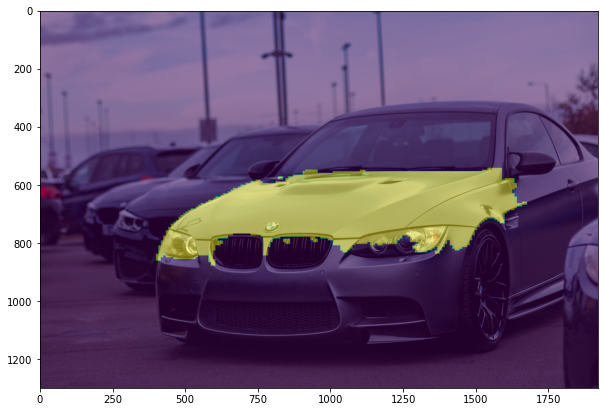

In [37]:
# Plot RLE Explainability mask over image. This model uses LIME to produce an explainable output RLE mask
rle_counts = model_results["data"]["explanation"]["maskRLE"]
img = cv2.cvtColor(cv2.imread('./bmw.jpg'),cv2.COLOR_BGR2RGB)
mask = display_rle_mask(img,rle_counts)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(mask,alpha=0.5)
plt.show()